In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Change default figsize
plt.rc("figure", figsize=(14, 7))

## Table of Contents
* [1. Forex Data](#1)
    * [1.1 Decomposition](#1_1)
    * [1.2 Autocorrelation and partial autocorrelation](#1_2)
* [2. Inflation rate](#2)
* [3. Unemployed rate](#3)
* [4. Foreign Direct Investment (FDI)](#4)
* [5. Correlation between all of the features](#5)

### **1. Forex Data <a class="anchor" id="1"></a>**

In [2]:
df_usd = pd.read_csv('../crawl/data/clean/df_usd.csv')
# Ensure 'Date' is in datetime format
df_usd['Date'] = pd.to_datetime(df_usd['Date'])
df = df_usd[df_usd['Date'] < '2024-01-01']
df

,Date,Buy Cash,Buy Transfer,Sell
0,2018-01-01,22625.0,22655.0,22735.0
1,2018-01-02,22645.0,22675.0,22745.0
2,2018-01-03,22645.0,22675.0,22745.0
3,2018-01-04,22645.0,22675.0,22745.0
4,2018-01-05,22645.0,22675.0,22745.0
...,...,...,...,...
2185,2023-12-27,24110.0,24140.0,24480.0
2186,2023-12-28,24030.0,24060.0,24400.0
2187,2023-12-29,24050.0,24080.0,24420.0
2188,2023-12-30,24050.0,24080.0,24420.0


In [3]:
df['Sell'].describe()

count     2190.000000
mean     23372.473059
std        460.501878
min      22720.000000
25%      23120.000000
50%      23270.000000
75%      23530.000000
max      25481.000000
Name: Sell, dtype: float64

- The interquartile range (IQR), which is the difference between the 75th and 25th percentiles, is 410 (23.530 - 23.120). This indicates the middle 50% of the data is concentrated within this range, showing moderate variability.
- The close proximity of the median (23.270) to the mean (23.372,47) suggests a relatively symmetrical distribution of exchange rates, though the presence of outliers (as indicated by the min and max values) could skew the distribution slightly.

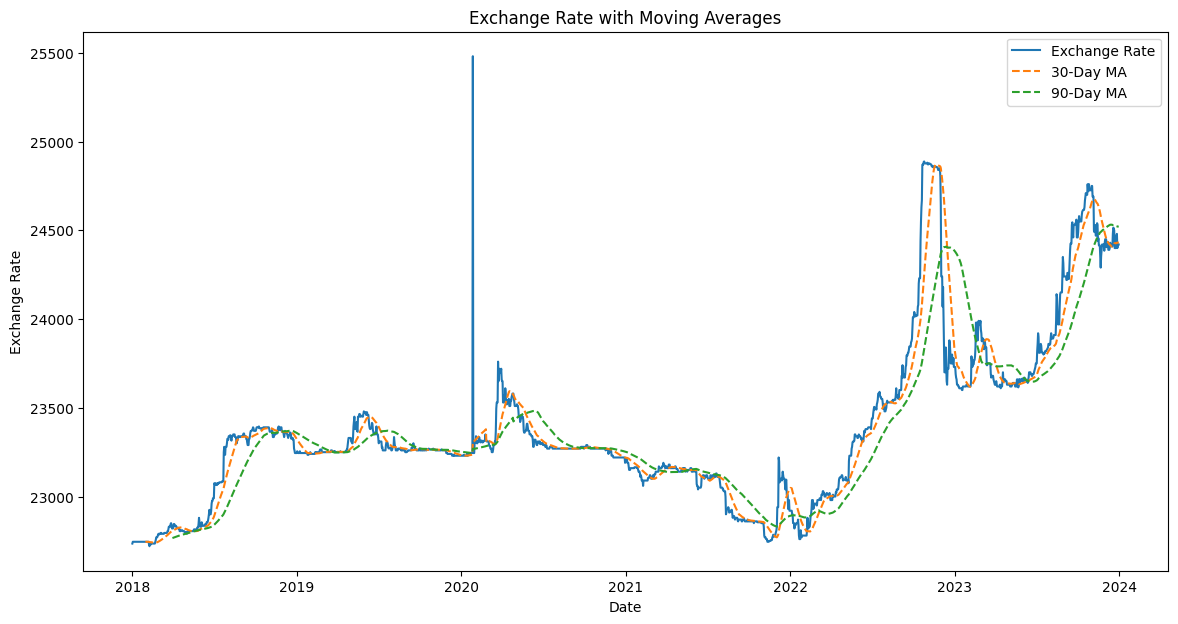

In [4]:
# Plot moving averages plot
df_tmp = df.copy()
df_tmp['MA30'] = df['Sell'].rolling(window=30).mean()
df_tmp['MA90'] = df['Sell'].rolling(window=90).mean()

plt.plot(df_tmp['Date'], df_tmp['Sell'], label='Exchange Rate')
plt.plot(df_tmp['Date'], df_tmp['MA30'], label='30-Day MA', linestyle='--')
plt.plot(df_tmp['Date'], df_tmp['MA90'], label='90-Day MA', linestyle='--')
plt.title('Exchange Rate with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

- From the beginning of the series (2018) to the end (2024), the exchange rate has experienced several significant fluctuations.
- There is a notable upward trend starting around early 2022, indicating a general increase in the exchange rate over this period.


In [5]:
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
df_tmp.set_index('Date', inplace=True)

#### **1.1 Decomposition <a class="anchor" id="1_1"></a>**

Any time series distribution has 3 core components:
1. Seasonality - does the data have a clear cyclical/periodic pattern?
2. Trend - does the data represent a general upward or downward slope?
3. Noise - what are the outliers or missing values that are not consistent with the rest of the data?

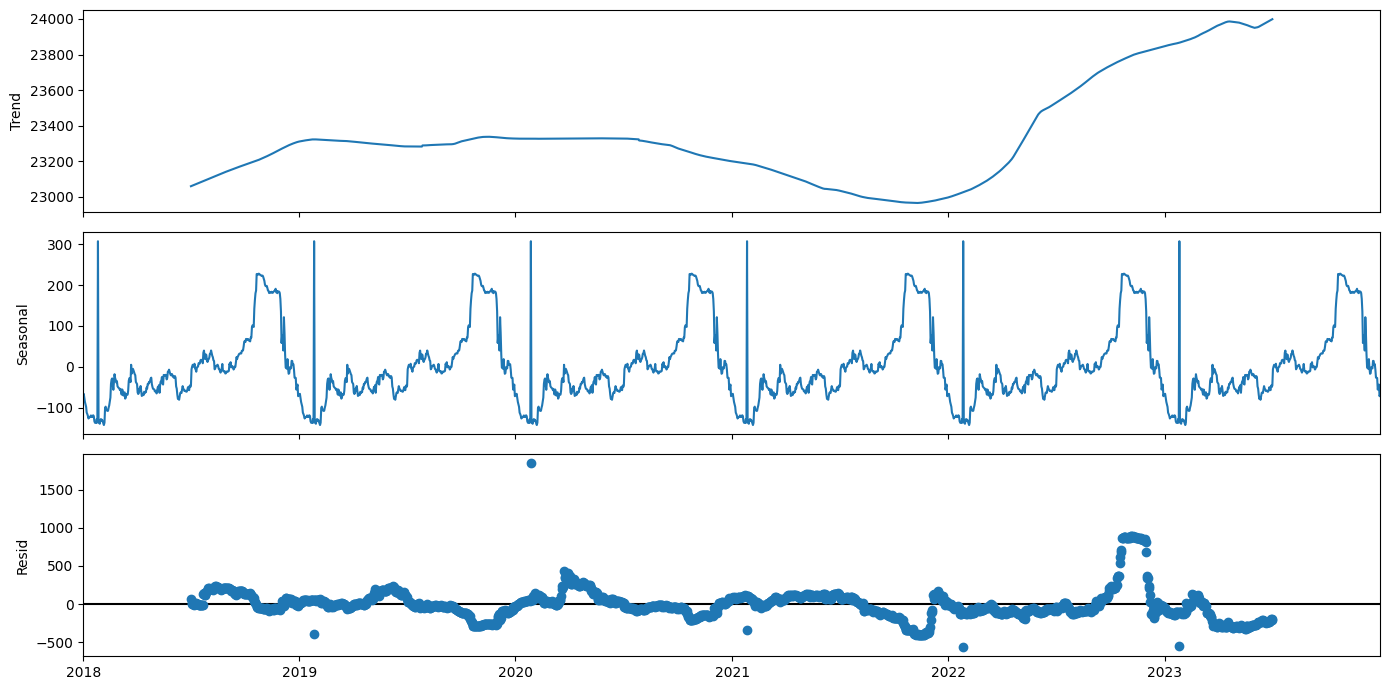

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_tmp['Sell'], model='additive', period=365)
result.plot(observed=False)
plt.show()

Daily data might not have a clear seasonal pattern. But as we can see in the plot:
- The trend shows a slight decline from mid-2020 to near the end of 2021, capturing the economic slowdown and uncertainty due to the pandemic.
- From early 2022 onwards, the trend shifts to a gradual upward movement, indicating recovery and stabilization efforts as economies adjusted to the pandemic's impacts and began to recover.

#### **1.2 Autocorrelation and partial autocorrelation <a class="anchor" id="1_2"></a>**
The correlation between observations at different lags, which is crucial for time series modeling.

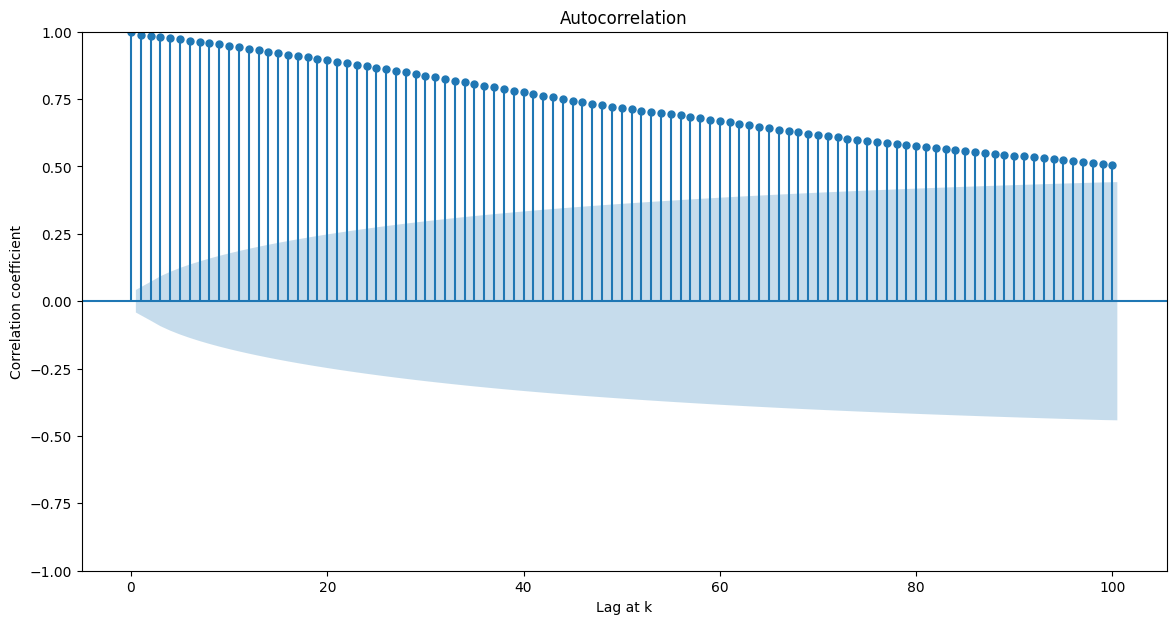

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_tmp['Sell'], lags=100)
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

For the first few lag values, the exchange rate data shows strong correlations with its past values, and these correlations are strong enough to be unlikely due to random chance. This is important for time series analysis because it suggests that past values can be useful in predicting future values &#8594; Models like ARIMA or Transformer models for time series forecasting can leverage this autocorrelation to improve prediction accuracy.

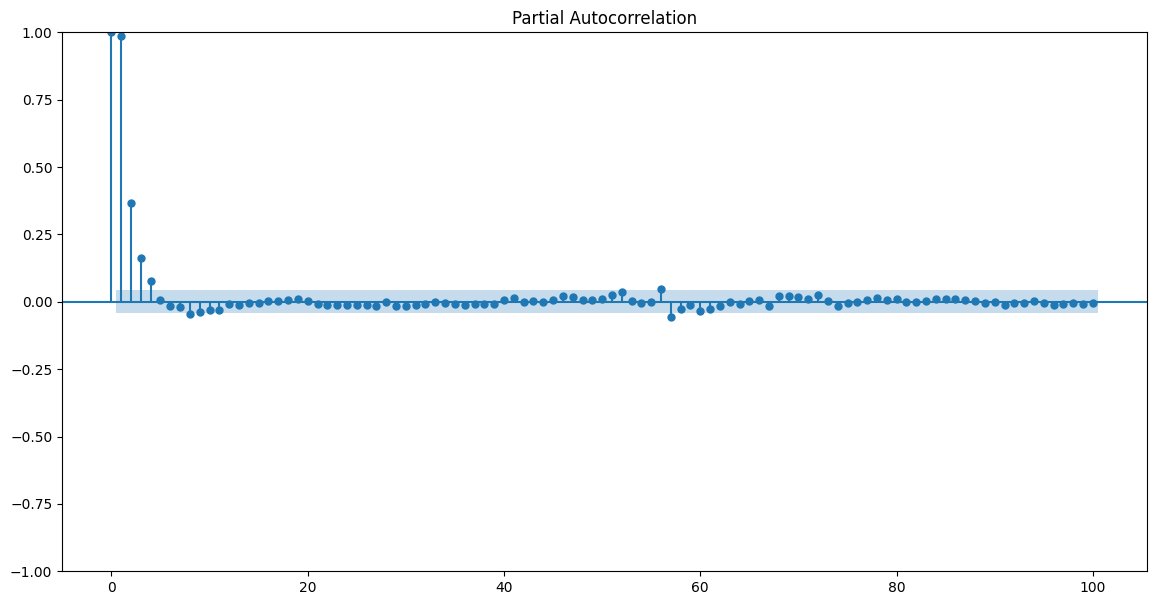

In [8]:
plot_pacf(df_tmp['Sell'], lags=100)
plt.show()

As the lag increases, the partial autocorrelation values become insignificant, indicating that the influence of past values diminishes as we go further back in time &#8594; Given the high partial autocorrelation at the first few lags, autoregressive (AR) models might be appropriate for modeling this time series

### **2. Inflation rates <a class="anchor" id="2"></a>**

In [10]:
df_inflation = pd.read_csv('../crawl/data/trading_economics/inflation_rate_month.csv')
df_inflation['Date'] = pd.to_datetime(df_inflation['month'], format='%d-%m-%y')
df = df_inflation[df_inflation['Date'] < '2024-01-01']
df

,month,inflation_rate_vn,inflation_rate_us,Date
0,01-01-18,0.0265,0.021,2018-01-01
1,01-02-18,0.0315,0.022,2018-02-01
2,01-03-18,0.0266,0.024,2018-03-01
3,01-04-18,0.0275,0.025,2018-04-01
4,01-05-18,0.0386,0.028,2018-05-01
...,...,...,...,...
67,01-08-23,0.0296,0.037,2023-08-01
68,01-09-23,0.0366,0.037,2023-09-01
69,01-10-23,0.0359,0.032,2023-10-01
70,01-11-23,0.0345,0.031,2023-11-01


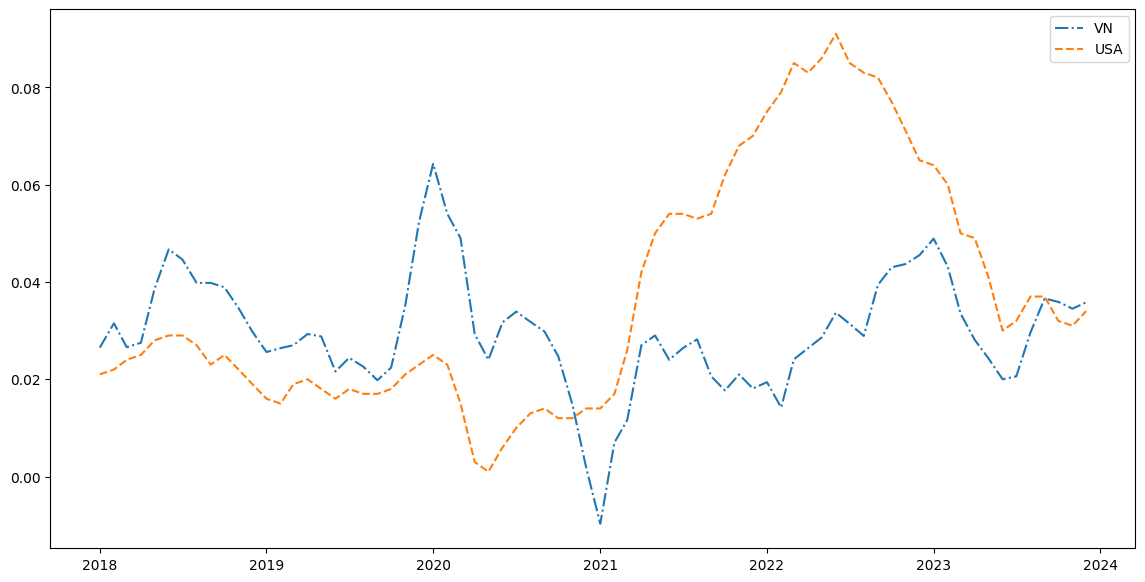

In [14]:
plt.plot(df['Date'], df['inflation_rate_vn'], label = "VN", linestyle="-.") 
plt.plot(df['Date'], df['inflation_rate_us'], label = "USA", linestyle="--") 
plt.legend() 
plt.show()

- In the early part of the observed period (2018-2019), both countries have relatively low and stable inflation rates.
- The impact of the COVID-19 pandemic is evident in both countries' inflation data, but the USA experiences a more pronounced and sustained increase in inflation starting from 2021.
- Vietnam's inflation rate shows more frequent fluctuations and sharper peaks, possibly reflecting more immediate impacts of external economic shocks and policy measures.

### **3. Unemployed rates <a class="anchor" id="3"></a>**

In [25]:
df_unemploy = pd.read_csv('../crawl/data/trading_economics/df_unemploy_quarter.csv')
df = df_unemploy[df_unemploy['Date'] < '2024-01-01']
df

,Date,unemploy_rate_us,unemploy_rate_vn
0,2018-01-01,0.040333,0.0219
1,2018-04-01,0.039333,0.0220
2,2018-07-01,0.037667,0.0218
3,2018-10-01,0.038333,0.0219
4,2019-01-01,0.038667,0.0217
5,2019-04-01,0.036333,0.0216
6,2019-07-01,0.036000,0.0217
7,2019-10-01,0.036000,0.0215
8,2020-01-01,0.038333,0.0222
9,2020-04-01,0.130667,0.0273


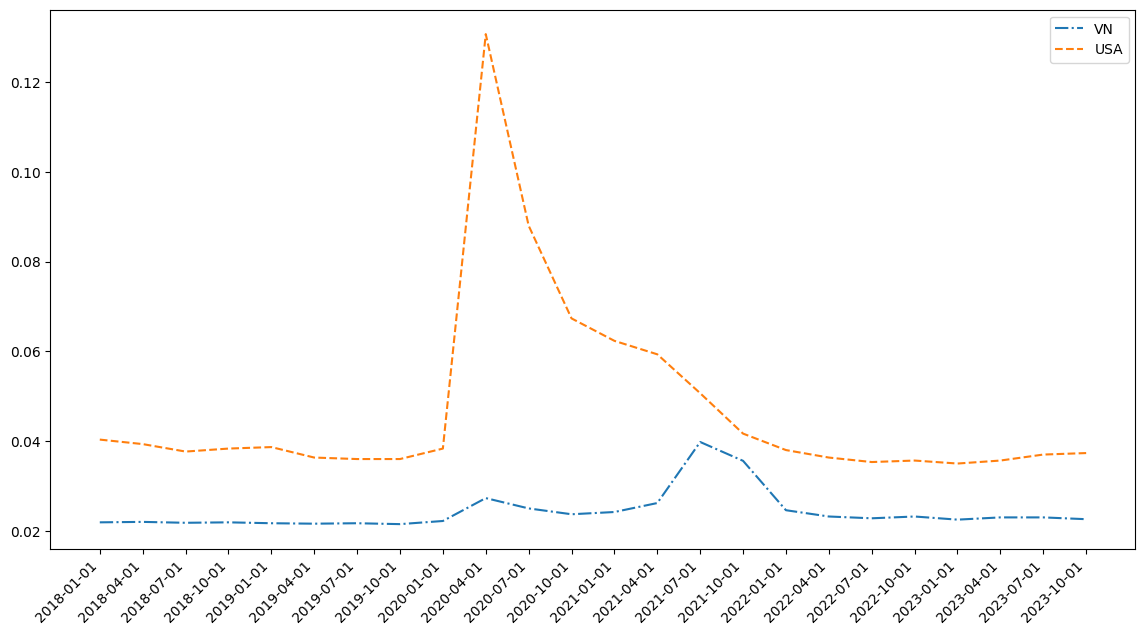

In [26]:
plt.plot(df['Date'], df['unemploy_rate_vn'], label = "VN", linestyle="-.") 
plt.plot(df['Date'], df['unemploy_rate_us'], label = "USA", linestyle="--") 
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.show()

- Vietnam's unemployment appears consistently lower than the US throughout the period.
- Both countries exhibit fluctuations in unemployment rates.

### **4. Foreign Direct Investment (FDI) <a class="anchor" id="4"></a>**

In [27]:
df_unemploy = pd.read_csv('../crawl/data/trading_economics/df_fdi_quarter.csv')
df = df_unemploy[df_unemploy['Date'] < '2024-01-01']
df

,Date,fdi_vn,fdi_us
0,2018-01-01,2.213333,43.0
1,2018-04-01,6.740000,53.9
2,2018-07-01,11.450000,54.5
3,2018-10-01,16.900000,52.2
4,2019-01-01,2.750000,45.9
5,2019-04-01,7.366667,50.3
6,2019-07-01,12.243333,48.3
7,2019-10-01,18.070000,52.1
8,2020-01-01,2.633333,30.4
9,2020-04-01,6.833333,24.7


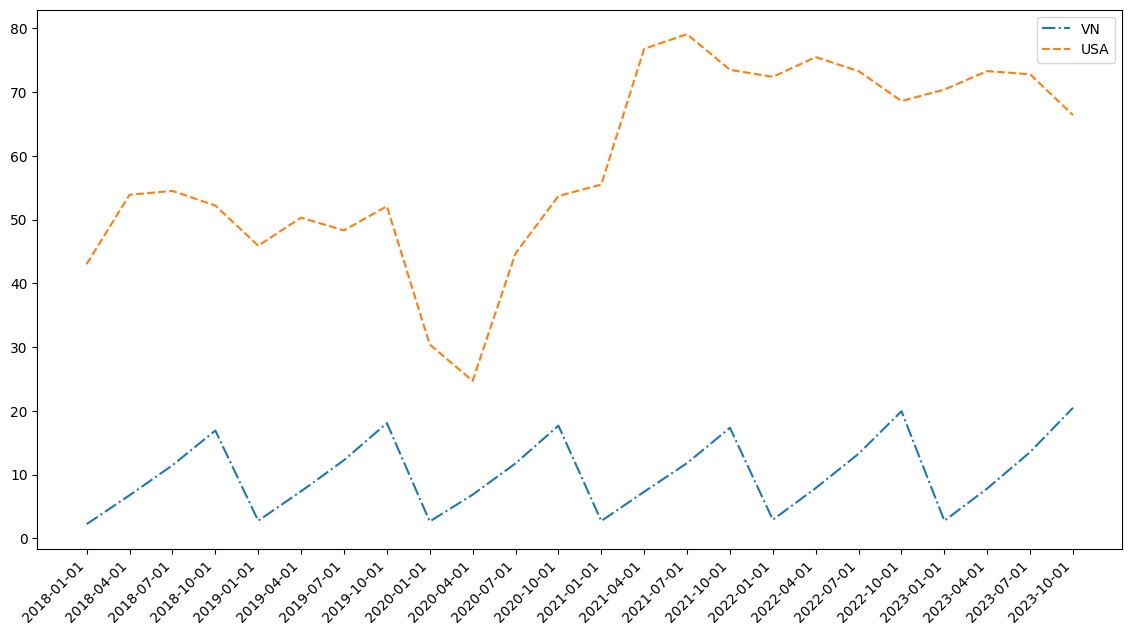

In [29]:
plt.plot(df['Date'], df['fdi_vn'], label = "VN", linestyle="-.") 
plt.plot(df['Date'], df['fdi_us'], label = "USA", linestyle="--") 
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.show()

- The US has a higher FDI than Vietnam over the time period shown
- The US shows a possible flat or slightly decreasing trend in FDI, while Vietnam exhibits a potential upward trend

### **5. Correlation between all of the features <a class="anchor" id="5"></a>**

In [31]:
import seaborn as sns

df_usd = pd.read_csv('../crawl/data/clean/df_combine.csv')
# Ensure 'Date' is in datetime format
df_usd['Date'] = pd.to_datetime(df_usd['Date'])
df = df_usd[df_usd['Date'] < '2024-01-01']
df.set_index('Date', inplace=True)
df

,Buy Cash,Buy Transfer,Sell,inflation_rate_vn,inflation_rate_us,unemploy_rate_us,unemploy_rate_vn,fdi_vn,fdi_us
Date,,,,,,,,,
2018-01-01,22625.0,22655.0,22735.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2018-01-02,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2018-01-03,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2018-01-04,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
2018-01-05,22645.0,22675.0,22745.0,0.0265,0.021,0.040333,0.0219,2.213333,43.0
...,...,...,...,...,...,...,...,...,...
2023-12-27,24110.0,24140.0,24480.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4
2023-12-28,24030.0,24060.0,24400.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4
2023-12-29,24050.0,24080.0,24420.0,0.0358,0.034,0.037333,0.0226,20.476667,66.4


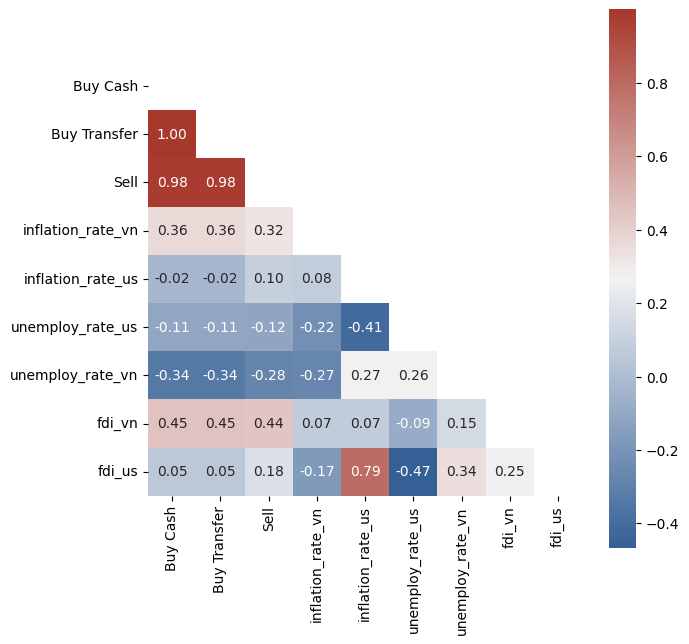

In [32]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = df.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show()

- Strong positive correlation: If two features have a strong positive correlation (dark blue), their values tend to move in the same direction. For example, a high buy cash rate might coincide with a high sell rate.
- Strong negative correlation: Conversely, a strong negative correlation (dark red) indicates the features tend to move in opposite directions. For instance, a high inflation rate in Vietnam (VN) might be associated with a lower sell rate.

- We can see that Vietnam feature have more impact on ourr target (Sell price)